# Vortex dynamics analysis with Γ1 and Γ2 functions.

Γ1 and Γ2 functions were introduced in L.Graftieaux, M. Michard, N. Grosjean, "Combining PIV, POD and vortex identification algorithms for the study of unsteady turbulent swirling flows", Meas.Sci.Technol., 12(2001), p.1422-1429. Γ1 function is used to identify the locations of the centers of the vortices (which are given by the Γ1 peak values within the velocity field). Γ2 function is used to identify the boundaries of the vortices in a velocity field.

They are implemented in PIVPY package, specifically, for big datasets. To compute them, one must apply their formulas in a neigborhood of every velocity vector within the velocity field. The results of the formulas are scalars wich are assigned to the position of the given velocity vector. And we end up having Γ1 and Γ2 scalar fields.

PIVPY stores time series of velocity fields as piv objects (which are extensions of Xarray class). The Γ1 and Γ2 formulas for a neigborhoud of the velocity vector are implemented in the functions `Γ1_moving_window_function()` and `Γ2_moving_window_function()` located in `compute_funcs.py` module of PIVPY package.

The methods of piv class `Γ1()` and `Γ2()` start with "constructing" a "rolling (or moving) window" which has the user-picked size of the neighborhood of every velocity vector and goes from one velocity vector to another applying `Γ1_moving_window_function()` and `Γ2_moving_window_function()` to its neighborhood.

`Γ1()` and `Γ2()` methods do that in parallel. They break the entier dataset of velocity fields on chunks using Dask-inspired function `.map_blocks()` and perform the above described calculations for every chunk in parallel. 

Upon extensive testing, this design was proven to be the fastest one. 

Note, it is not fast for small datasets because the mechanism of Dask is known to become fast only for big datasets and it, actually, slows down the calculations for small datasets. Thus - during the tests - it was discovered that a small dataset of $10$ velocity fields would take on the order of $800s$ to compute Γ1, whereas a big dataset of $500$ velocity fields would take on the order of $2400s$ to compute Γ1. I.e., the computing time increased only by the factor of $3$ whereas the dataset increased by the factor of $50$. The gains in speed are anticipated to be even better when the dataset increases even more.

Also note, that Jupiter notebook takes more computing time than a regular console-based python programme for the same task.

This tutorial uses only two velocity fields, because, otherwise, it would take a lot of time to obtain Γ1 and Γ2 fields.

### An example with a custom flow.
For the first example, let's use a custom bubble driven upward water flow along an inclined wall.

In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from pivpy import io, pivpy, graphics
from openpiv import pyprocess, scaling, tools
import pkg_resources as pkg


In [2]:
# The example velocity field are stored as OpenPIV .txt files in the packaged data directory.
fieldsDir = pathlib.Path(pkg.resource_filename('pivpy', 'data/openpiv_txt/Gamma1_Gamma2_tutorial_notebook'))


In [3]:
# Global variables
n = 4 # the size of the neighborhood around every velocity vector is given by (2*n+1) x (2*n+1);

In [4]:
# Load our time series of two velocity fields as a piv object of PIVPY package:
dataBaseXarray = io.load_directory(
    path = fieldsDir,
    basename = "OpenPIVtxtFilePair?",
    ext = ".txt"
)

found 2 files


In [5]:
# Compute Γ1 simultaneously adding it as a DataArray to dataBaseXarray Dataset.
# To compute either Γ1 or Γ2, the function must create additional DataArrays within dataBaseXarray Dataset.
# Those additional DataArrays just store the x and y coordinates of the velocity field as DataArrays 
# within dataBaseXarray Dataset and their names are xCoordinates and yCoordinates. Since we are running
# Γ1 for the first time, we haven't created xCoordinates and yCoordinates yet. That's why we must give 
# True to the argument convCoords below.
dataBaseXarray.piv.Γ1(n, convCoords=True)

C:\Users\nepomnyi\Box\OpenPIVdevelopment\pivpy\pivpy\compute_funcs.py:65: RuntimeWarning: Mean of empty slice
  Γ1 = np.nanmean(np.divide(np.subtract(np.multiply(PMx,v), np.multiply(PMy,u)), np.multiply(np.sqrt(np.add(np.square(PMx), np.square(PMy))), np.sqrt(np.add(np.square(u), np.square(v))))))


<xarray.Dataset>
Dimensions:       (x: 79, y: 63, t: 2)
Coordinates:
  * x             (x) float64 0.9412 1.882 2.824 3.765 ... 72.47 73.41 74.35
  * y             (y) float64 59.29 58.35 57.41 56.47 ... 2.824 1.882 0.9412
  * t             (t) int32 0 1
Data variables:
    u             (x, y, t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    v             (x, y, t) float64 -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0 -0.0
    chc           (x, y, t) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    xCoordinates  (x, y, t) float64 0.9412 0.9412 0.9412 ... 74.35 74.35 74.35
    yCoordinates  (x, y, t) float64 59.29 59.29 58.35 ... 1.882 0.9412 0.9412
    Γ1            (x, y, t) float64 -0.08944 0.2445 -0.05214 ... 0.0 0.0 0.0
Attributes:
    delta_t:  0.0
    files:    [WindowsPath('../../pivpy/data/openpiv_txt/Gamma1_Gamma2_tutori...

Notice the warning about empty slice above. It appears because we have regions without flow in our example velocity fields (thouse regions are, actually, a wall).

In [6]:
# Compute Γ2 simultaneously adding it as a DataArray to dataBaseXarray Dataset.
dataBaseXarray.piv.Γ2(n, convCoords=False) # False flag used, because the coordinates have already been 
                                           # converted at the previous line and we can speed up the 
                                           # calculations by not converting the coordinates again; see 
                                           # the comment in the cell above

C:\Users\nepomnyi\Box\OpenPIVdevelopment\pivpy\pivpy\compute_funcs.py:137: RuntimeWarning: Mean of empty slice
  Γ2 = np.nanmean(np.divide(np.subtract(np.multiply(PMx,vDif), np.multiply(PMy,uDif)), np.multiply(np.sqrt(np.add(np.square(PMx), np.square(PMy))), np.sqrt(np.add(np.square(uDif), np.square(vDif))))))


<xarray.Dataset>
Dimensions:       (x: 79, y: 63, t: 2)
Coordinates:
  * x             (x) float64 0.9412 1.882 2.824 3.765 ... 72.47 73.41 74.35
  * y             (y) float64 59.29 58.35 57.41 56.47 ... 2.824 1.882 0.9412
  * t             (t) int32 0 1
Data variables:
    u             (x, y, t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    v             (x, y, t) float64 -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0 -0.0
    chc           (x, y, t) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    xCoordinates  (x, y, t) float64 0.9412 0.9412 0.9412 ... 74.35 74.35 74.35
    yCoordinates  (x, y, t) float64 59.29 59.29 58.35 ... 1.882 0.9412 0.9412
    Γ1            (x, y, t) float64 -0.08944 0.2445 -0.05214 ... 0.0 0.0 0.0
    Γ2            (x, y, t) float64 -0.1198 -0.349 -0.1875 ... 0.0 0.0 0.0
Attributes:
    delta_t:  0.0
    files:    [WindowsPath('../../pivpy/data/openpiv_txt/Gamma1_Gamma2_tutori...

Notice the warning about empty slice above. It appears because we have regions without flow in our example velocity fields (thouse regions are, actually, a wall).

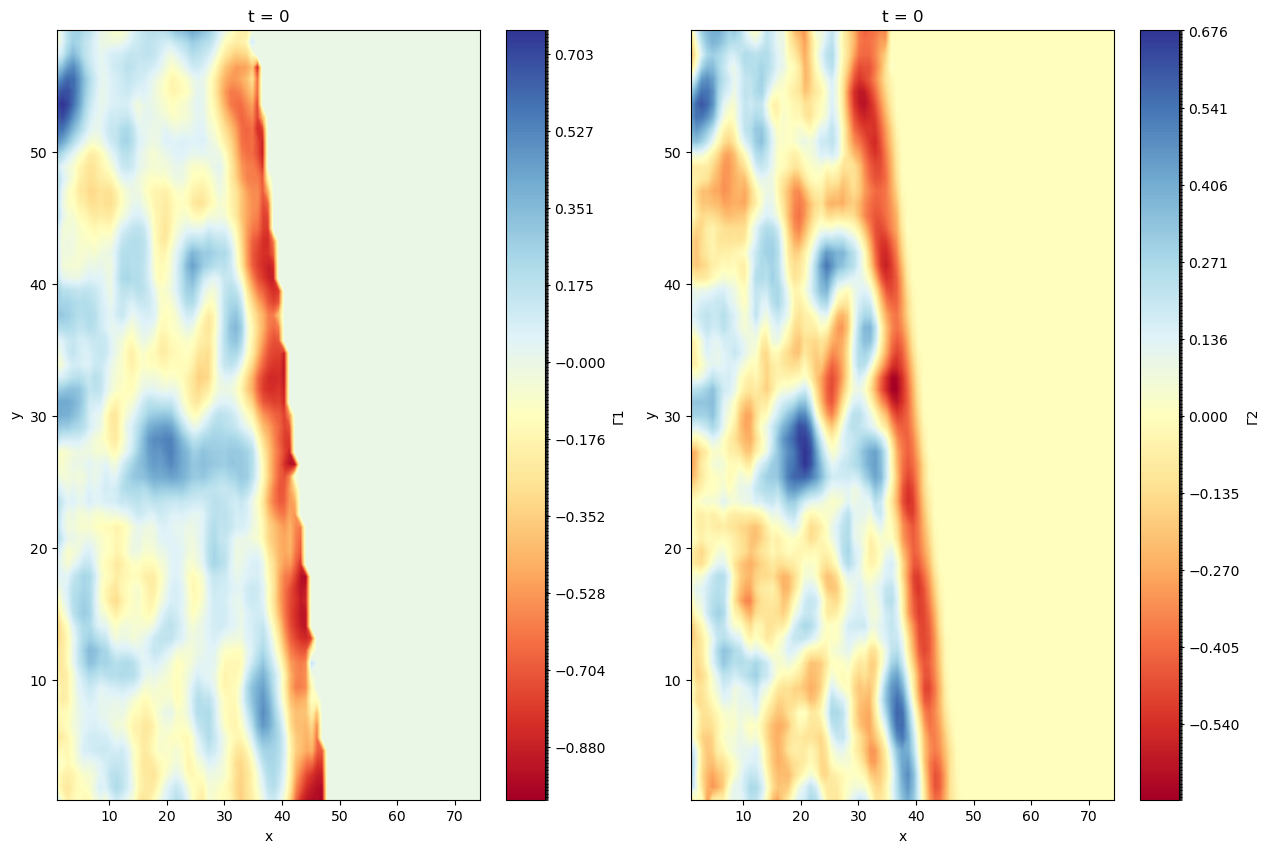

In [7]:
# Plot Γ1 and Γ2 fields.

def _safe_levels(da, n=1000):
    vmin = float(da.min().values)
    vmax = float(da.max().values)
    if vmin == vmax:
        eps = 1e-12 if vmin == 0 else abs(vmin) * 1e-12
        return [vmin - eps, vmax + eps]
    return np.linspace(vmin, vmax, n)

# For t=0
levelsΓ1 = _safe_levels(dataBaseXarray['Γ1'].isel(t=0))
levelsΓ2 = _safe_levels(dataBaseXarray['Γ2'].isel(t=0))

figΓ, axΓ = plt.subplots(nrows=1, ncols=2, clear=True, num='figGamma', figsize=(15,10))
dataBaseXarray['Γ1'].isel(t=0).plot.contourf(x='x', y='y', levels=levelsΓ1, cmap=plt.get_cmap('RdYlBu'), ax=axΓ[0])
dataBaseXarray['Γ2'].isel(t=0).plot.contourf(x='x', y='y', levels=levelsΓ2, cmap=plt.get_cmap('RdYlBu'), ax=axΓ[1])


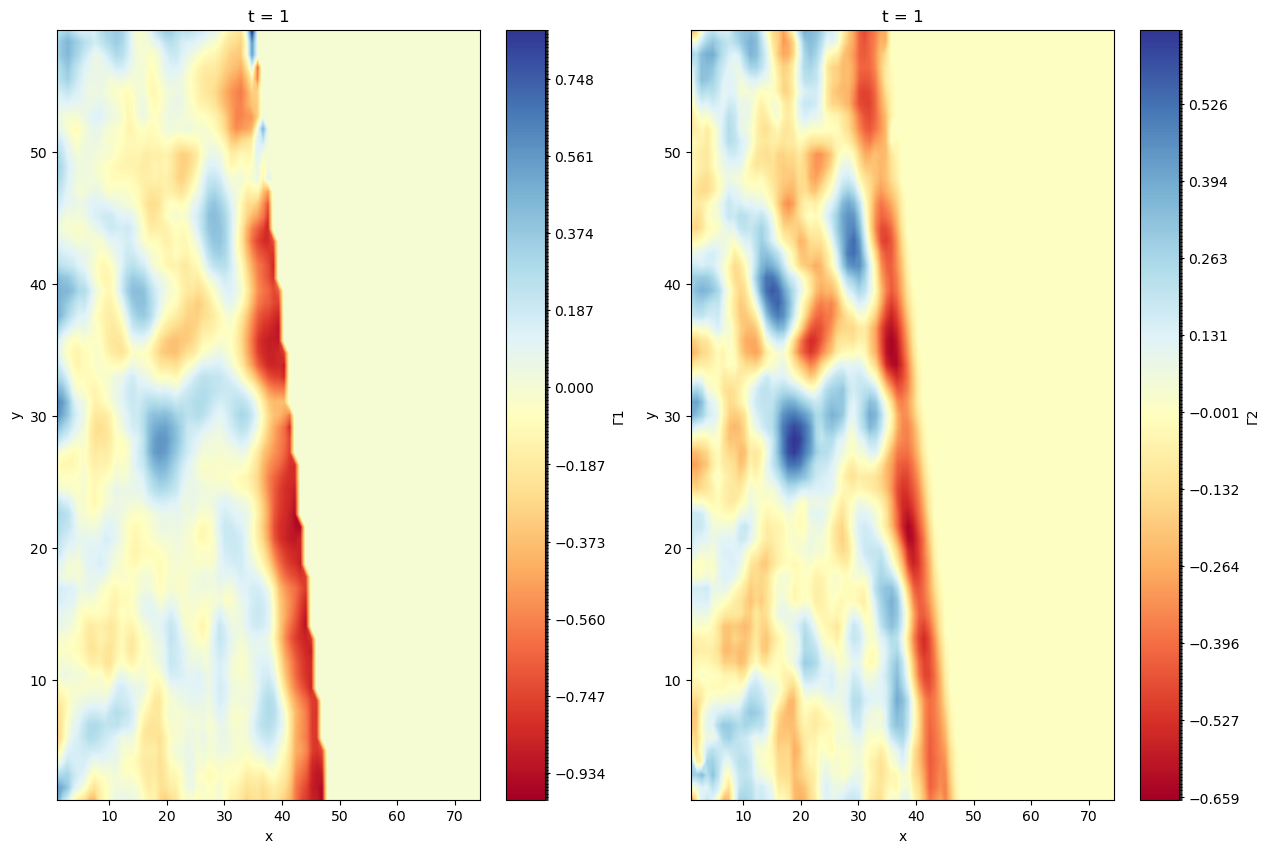

In [8]:
# For t=1
levelsΓ1 = _safe_levels(dataBaseXarray['Γ1'].isel(t=1))
levelsΓ2 = _safe_levels(dataBaseXarray['Γ2'].isel(t=1))

figΓ, axΓ = plt.subplots(nrows=1, ncols=2, clear=True, num='figGamma_t1', figsize=(15,10))
dataBaseXarray['Γ1'].isel(t=1).plot.contourf(x='x', y='y', levels=levelsΓ1, cmap=plt.get_cmap('RdYlBu'), ax=axΓ[0])
dataBaseXarray['Γ2'].isel(t=1).plot.contourf(x='x', y='y', levels=levelsΓ2, cmap=plt.get_cmap('RdYlBu'), ax=axΓ[1])


Once the Γ1 and Γ2 fields have been obtained (as the parts of the Xarray dataset), one can do different things with them. For instance, one can plot them as shown above. 

Another thing one can do with them is to obtain the coordinates of the centers of the vortices and their sizes. 

Thus per the referenced article, Γ1 values must reach maximum at the vortex center. On the above plots of Γ1, we can see the maximum positive (presumably counter clockwise vortex) and negative (presumably clockwise vortex) values to be between about $-0.9$ and $0.7$. One can apply a treshold of, say, $20\%$ and claim that the centers of the vortices are located in the areas where |Γ1| > 0.8*|Γ1|.

The same thing can be done with Γ2. The referenced article offers a threshold of $2\pi$ for the boundaries of the vortices. It "defines the inner core of the vortex as the part of the flow where |Γ2| exceeds a given threshold, typically in the range $0.6-0.7$ (approximately $2\pi$)." Another piece of knowledge the referenced article gives us is that for |Γ2|<$2\pi$ the flow is dominated by strain locally, for |Γ2|=$2\pi$ the flow is a pure shear flow locally and for |Γ2|>$2\pi$ the flow is dominated by rotation locally.

As it was mentioned in the preamble to this example, we are looking at bubble driven vertical flow along an inclined wall. Those right hand sides of the plots with absolutely uniform colors represent the wall. There is no flow there and, therefore, our $\Gamma 1$ and $\Gamma 2$ functions found no vortices there. However, we can see primarily red inclined stretch in the middle of the plots. This is the wall along which the bubbles are rising in chain and creating swirls in the water. The colors are rich there - we have strong swirls there. At the left most vertical edge of the plots we see primarily blue and yellow colors, which according to the colorbars, correspond to positive vortices. It so happens that the left most edge of the plots coincide with the wall of the vessel where this flow occurs. There are no bubbles rising alon that wall. So, you may conclude now that the strongest vortices appear on the walls (where the largest shear occurs) and the vortices on the opposite walls "spin" in the opposite directions. And since the bubbles are rising in chain only along the right wall (i.e., the inclined wall), the vortices are much "stronger" there than along the left vertical wall.

### A strong vortex example.
Now, let's see what we get for a standard vortex. The example PIV images for this task were taken from the PIV challenge website and all the credit for the images goes there (https://www.pivchallenge.org/pub/index.html#a).

In [9]:
# Start with a quick OpenPIV-based function to obtain the velocity fields from the PIV images.
def PIVanalysis(frameA, frameB, nameTXT):
    """
    The function goes through the directory containing frames A and B of PIV images and calculates 
    velocity fields for them. Then, it stores them as OpenPIV .txt files.
    Parameters: frameA (str) - the path to frame A of the PIV pair of images
                frameB (str) - the path to frame B of the PIV pair of images
                nameTXT (str) - name of the .txt file to save the velocity field to
    Returns: none
    """
    dataArray = np.asarray([tools.imread(frameA), tools.imread(frameB)]) # 0 flag = read as gray scale

    # Find the correlations map. Hard code 32 as search area size and 16 as overlap.
    corrs = pyprocess.fft_correlate_images(
        pyprocess.moving_window_array(dataArray[0],32,16),
        pyprocess.moving_window_array(dataArray[1],32,16),
        normalized_correlation=True,
        correlation_method="linear"
    )
    mesh = pyprocess.get_field_shape(dataArray[0].shape, 32, 16)
    nrows, ncols = mesh[0], mesh[1]

    # Find the displacements in pix.
    xDisp, yDisp = pyprocess.correlation_to_displacement(corrs, nrows, ncols)
    # We are not going to calculate velocities because we don't know Δt. I.e., we going to work
    # with the displacement vectoras as if they were velocity vectors (or, if you want, assume Δt=1).

    x, y = pyprocess.get_coordinates(dataArray[0].shape, 32, 16)

    x, y, xDisp, yDisp = scaling.uniform(x, y, xDisp, yDisp, scaling_factor = 1)

    tools.save(nameTXT, x, y, xDisp, yDisp)

    

In [10]:
# Obtain velocity field for PIV challenge case A.
caseAframeA = '../../pivpy/data/openpiv_txt/Gamma1_Gamma2_tutorial_notebook/StrongVortex/A/PIVchallengeCaseAframeA.jpg'
caseAframeB = '../../pivpy/data/openpiv_txt/Gamma1_Gamma2_tutorial_notebook/StrongVortex/A/PIVchallengeCaseAframeB.jpg'
caseAnameTXT = '../../pivpy/data/openpiv_txt/Gamma1_Gamma2_tutorial_notebook/StrongVortex/A/PIVchallengeCaseAvelField.txt'
PIVanalysis(caseAframeA, caseAframeB, caseAnameTXT)

In [11]:
# Obtain velocity field for PIV challenge case B.
caseBframeA = '../../pivpy/data/openpiv_txt/Gamma1_Gamma2_tutorial_notebook/StrongVortex/B/PIVchallengeCaseBframeA.jpg'
caseBframeB = '../../pivpy/data/openpiv_txt/Gamma1_Gamma2_tutorial_notebook/StrongVortex/B/PIVchallengeCaseBframeB.jpg'
caseBnameTXT = '../../pivpy/data/openpiv_txt/Gamma1_Gamma2_tutorial_notebook/StrongVortex/B/PIVchallengeCaseBvelField.txt'
PIVanalysis(caseBframeA, caseBframeB, caseBnameTXT)

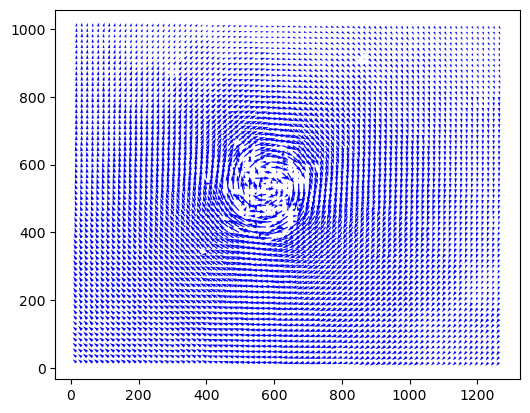

In [12]:
# Plot velocity field case A.
figure, _ = tools.display_vector_field(filename = caseAnameTXT,
                                       scaling_factor = 1,
                                       scale = 300,
                                       on_img = False,
                                       show_invalid = True
)
plt.show()

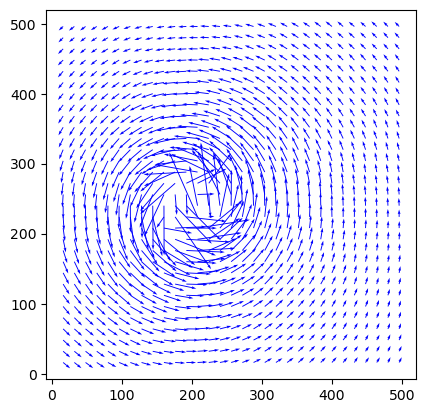

In [13]:
# Plot velocity field case B.
figure, _ = tools.display_vector_field(filename = caseBnameTXT,
                                       scaling_factor = 1,
                                       scale = 50,
                                       on_img = False,
                                       show_invalid = True
)
plt.show()

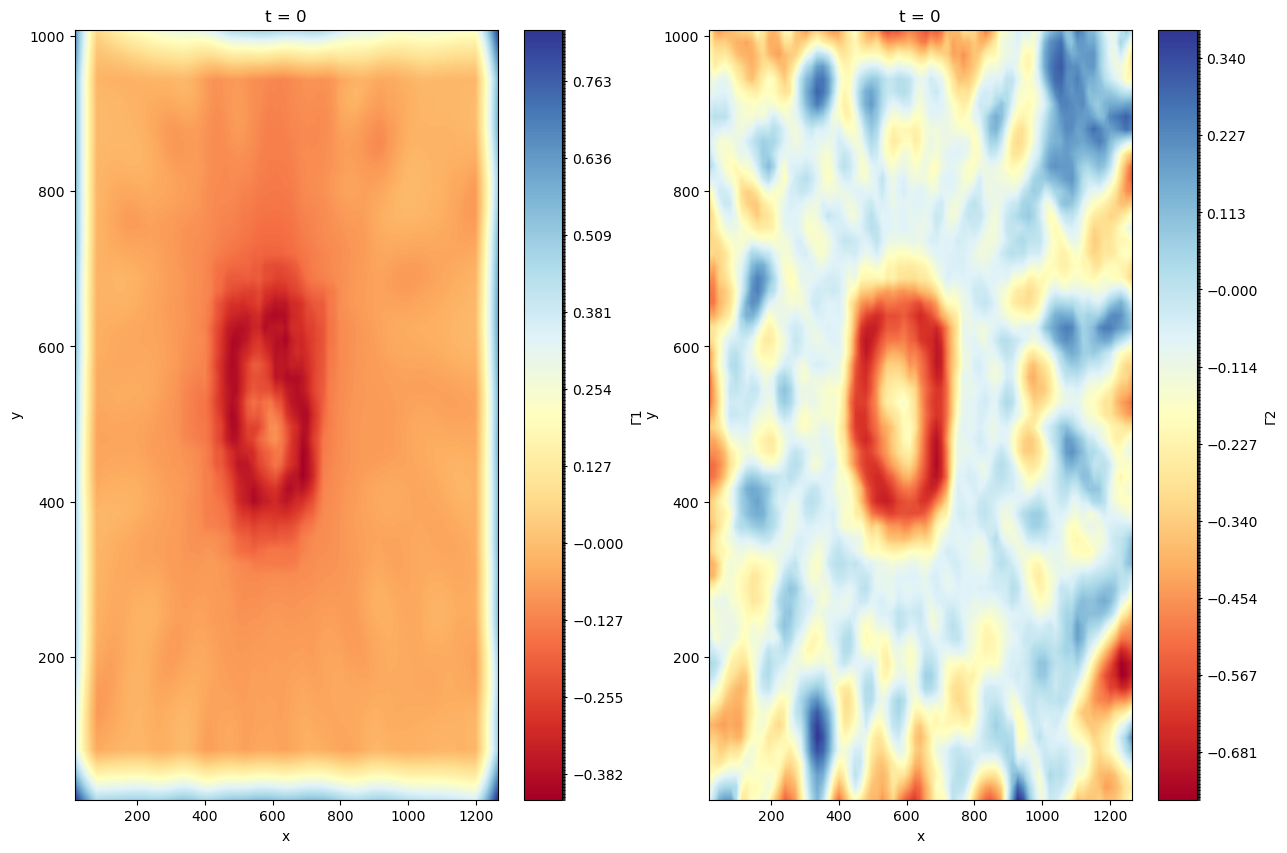

In [14]:
# Calculate Γ1, Γ2 and plot them for case A.
caseA = pathlib.Path(pkg.resource_filename('pivpy', 'data/openpiv_txt/Gamma1_Gamma2_tutorial_notebook/StrongVortex/A/PIVchallengeCaseAvelField.txt'))
dataBaseXarrayCaseA = io.load_openpiv_txt(filename=caseA, frame=0)

dataBaseXarrayCaseA.piv.Γ1(n, convCoords=True)
dataBaseXarrayCaseA.piv.Γ2(n, convCoords=False)

levelsΓ1 = _safe_levels(dataBaseXarrayCaseA['Γ1'].isel(t=0))
levelsΓ2 = _safe_levels(dataBaseXarrayCaseA['Γ2'].isel(t=0))
figΓ, axΓ = plt.subplots(nrows=1, ncols=2, clear=True, num='figGamma_caseA', figsize=(15,10))
dataBaseXarrayCaseA['Γ1'].isel(t=0).plot.contourf(x='x', y='y', levels=levelsΓ1, cmap=plt.get_cmap('RdYlBu'), ax=axΓ[0])
dataBaseXarrayCaseA['Γ2'].isel(t=0).plot.contourf(x='x', y='y', levels=levelsΓ2, cmap=plt.get_cmap('RdYlBu'), ax=axΓ[1])


One may notice the rings on the plots above and wonder why neither of $\Gamma$ functions monotoneously increases towards the center of the vortex. Have a look at the original PIV frames caseAframeA and caseAframeB: you'll see there are not PIV particles in the center of the vortex (all of them were driven towards the edges of the vortex by the centrifugal force, because the vortex was rather strong). And on the contrary to the referenced article, $\Gamma1$ doesn't reach $0.9-1$ at the center of the vortex. Remember, the threshold suggested in the referenced article was derived for a theoretical vortex. But $\Gamma2$ does exhibit the value of $2\pi = 0.6$ at the edges of the vortex. Of course just looking at the velocity field, it is difficult to understand where the edges of the vortex are. Evidently, $\Gamma2$ offers a consisten way for their identification.

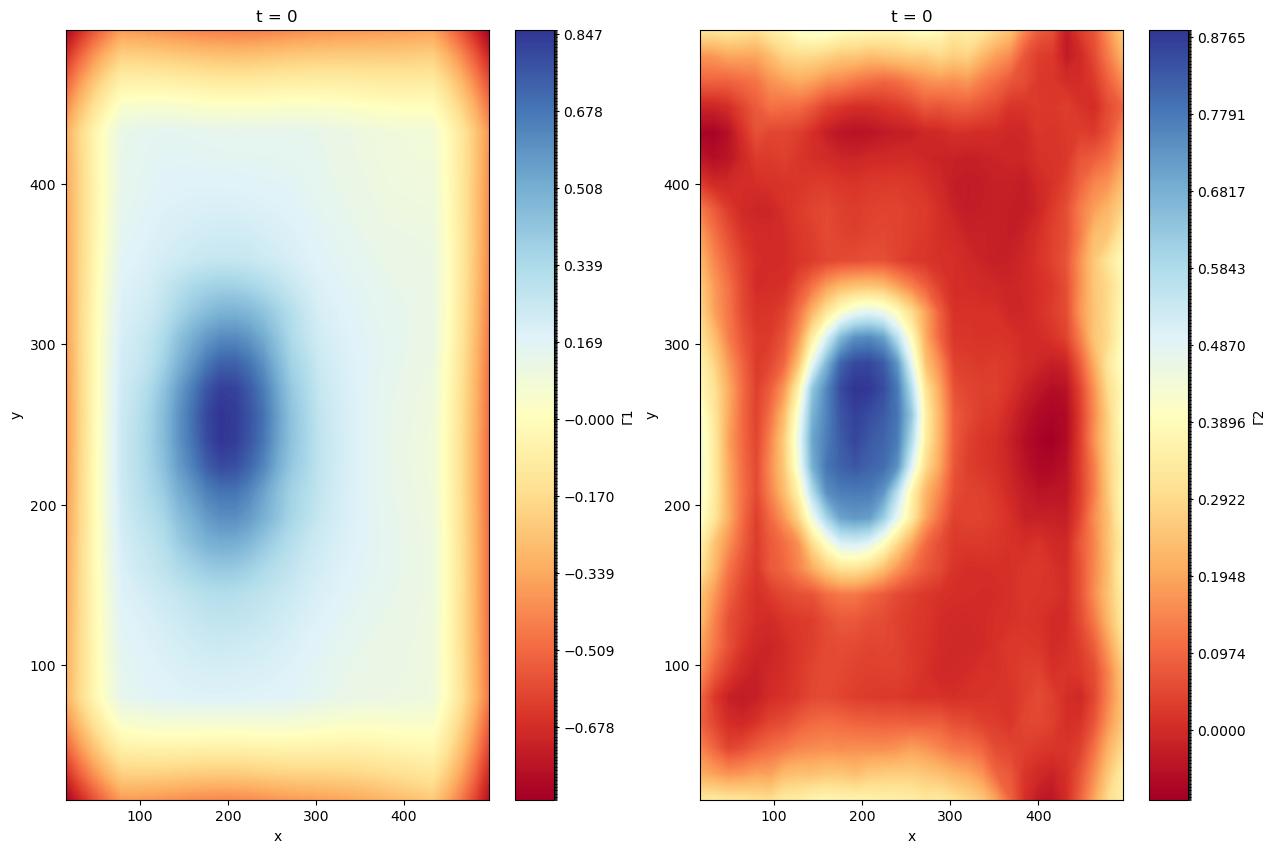

In [15]:
# Calculate Γ1, Γ2 and plot them for case B.
caseB = pathlib.Path(pkg.resource_filename('pivpy', 'data/openpiv_txt/Gamma1_Gamma2_tutorial_notebook/StrongVortex/B/PIVchallengeCaseBvelField.txt'))
dataBaseXarrayCaseB = io.load_openpiv_txt(filename=caseB, frame=0)

dataBaseXarrayCaseB.piv.Γ1(n, convCoords=True)
dataBaseXarrayCaseB.piv.Γ2(n, convCoords=False)

levelsΓ1 = _safe_levels(dataBaseXarrayCaseB['Γ1'].isel(t=0))
levelsΓ2 = _safe_levels(dataBaseXarrayCaseB['Γ2'].isel(t=0))
figΓ, axΓ = plt.subplots(nrows=1, ncols=2, clear=True, num='figGamma_caseB', figsize=(15,10))
dataBaseXarrayCaseB['Γ1'].isel(t=0).plot.contourf(x='x', y='y', levels=levelsΓ1, cmap=plt.get_cmap('RdYlBu'), ax=axΓ[0])
dataBaseXarrayCaseB['Γ2'].isel(t=0).plot.contourf(x='x', y='y', levels=levelsΓ2, cmap=plt.get_cmap('RdYlBu'), ax=axΓ[1])


On the contrary to case A, here we see no rings but rather monotoneously filled vortex. $\Gamma1$ monotoneously increases towards the center of the vortex and reaches its maximum of about $0.85$ at its center. And as you may notice, $0.85$ is not that far from $0.9$ suggested in the referenced article. In turn, $\Gamma 2$ - in spite of giving us the suggested threshold of $2\pi = 0.6$ - doesn't show a visually well defined boundary of the vortex (as opposed to case A, where, visually, the boundary of the vortex is obvious). And the last thing to notice is that the vortex in case B is blue, whereas the vortex in case A is red. Have a look at the color bars and you will notice that positive values lean toward the blue end of the colorbar, whereas negative values lean toward the red end of the colorbar. I.e., if the vortex is blue it's, presumably, counter clockwise (i.e., obeys the right hand rule) and if the the vortex is red it's, presumably, clock wise. And looking at the velocity fields for cases A and B, you will notice this is true.